#### This notebook would be used to run the code on reduced dataset which can then offer finer controls over the parameter space.

In [1]:
cd merity

/data/priyansh/new_kranti/merity


In [2]:
import model as merity

In [3]:
cd ..

/data/priyansh/new_kranti


In [4]:
# Torch imports
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import  DataLoader
from torch.nn.utils.rnn import pad_packed_sequence, pack_sequence 

# Local imports
import data_loader as dl
import auxiliary as aux
import network as net

# Other libs
from tqdm import tqdm
import numpy as np
import argparse
import time
import sys

from configs import config_loader as cl
import corechain as cc
import components as com
import utils.tensor_utils as tu

sys.path.append('/data/priyansh/conda/fastai')
from fastai.text import *
import fastai
from fastai import text, core, lm_rnn
from typing import Any, AnyStr, Callable, Collection, Dict, Hashable, Iterator, List, Mapping, NewType, Optional
import matplotlib.pyplot as plt


Loading ULMFIT vocab and vectors from disk. Sit Tight.
Label Cache not found. Creating a new one


Traceback (most recent call last):
  File "/data/priyansh/new_kranti/utils/dbpedia_interface.py", line 133, in __init__
    self.labels = pickle.load(open('resources/labels.pickle'))
TypeError: a bytes-like object is required, not 'str'


NOT IMPLEMENTED FUNCTIONALITY NOT IMPLEMENTED FUNCTIONALITY !!!


In [5]:
#setting up device,model name and loss types.
device = torch.device("cuda")
training_model = 'bilstm_dot_ulmfit'
_dataset = 'lcquad'
_train_over_validation = False
pointwise = False
_train_over_validation = False
finetune = False
bidirectional = True

#Loading relations file.
COMMON_DATA_DIR = 'data/data/common'
_dataset_specific_data_dir = 'data/data/%(dataset)s/' % {'dataset': _dataset}
_inv_relations = aux.load_inverse_relation(COMMON_DATA_DIR)
_word_to_id = aux.load_word_list(COMMON_DATA_DIR)

NOT IMPLEMENTED FUNCTIONALITY NOT IMPLEMENTED FUNCTIONALITY !!!


In [6]:
if pointwise:
    training_config = 'pointwise'
else:
    training_config = 'pairwise'

if training_model == 'reldet':
    schema = 'reldet'
elif training_model == 'slotptr' or training_model == 'slotptr_common_encoder' or training_model == 'slotptrortho':
    schema = 'slotptr'
elif training_model == 'bilstm_dot_multiencoder':
    schema = 'default'
else:
    schema = 'default'

In [7]:
parameter_dict = cl.corechain_parameters(dataset=_dataset,training_model=training_model,
                                             training_config=training_config,config_file='configs/macros.cfg')

parameter_dict['batch_size'] = 4000
if _dataset == 'lcquad':
    test_every = parameter_dict['test_every']
else:
    test_every = False
validate_every = parameter_dict['validate_every']


data = aux.load_data(_dataset=_dataset, _train_over_validation = _train_over_validation,
                     _parameter_dict=parameter_dict, _relations =  _inv_relations, _pointwise=pointwise, _device=device,k=1000)

train_loader = cc.load_data(data, parameter_dict, pointwise, schema=schema)

(700, 25)
(700, 25)
(700, 1000, 25)
(100, 25)
(100, 25)
(100, 1000, 25)
(200, 25)
(200, 25)
(200, 1000, 25)
(700, 25)


### Copy pasting the RNN core module from the fastai

In [27]:
import warnings
from fastai.imports import *
from fastai.torch_imports import *
from fastai.rnn_reg import LockedDropout,WeightDrop,EmbeddingDropout
from fastai.model import Stepper
from fastai.core import set_grad_enabled
import collections

from torch import Tensor
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pack_sequence
from typing import Sequence, Tuple, TypeVar, Union
# from .imports.core import *
# from fastai.imports.core import *
# IS_TORCH_04 = LooseVersion(torch.__version__) >= LooseVersion('0.4')

def seq2seq_reg(output, xtra, loss, alpha=0, beta=0):
    hs,dropped_hs = xtra
    if alpha:  # Activation Regularization
        loss = loss + (alpha * dropped_hs[-1].pow(2).mean()).sum()
    if beta:   # Temporal Activation Regularization (slowness)
        h = hs[-1]
        if len(h)>1: loss = loss + (beta * (h[1:] - h[:-1]).pow(2).mean()).sum()
    return loss

def repackage_var(h):
    """Wraps h in new Variables, to detach them from their history."""
    if IS_TORCH_04: return h.detach() if type(h) == torch.Tensor else tuple(repackage_var(v) for v in h)
    else: return Variable(h.data) if type(h) == Variable else tuple(repackage_var(v) for v in h)
    
# def dropout_mask(x,sz,p):
#     "Return a dropout mask of the same type as x, size sz, with probability p to cancel an element."
#     return x.new(*sz).bernoulli_(1-p).div_(1-p)

# class RNNDropout(nn.Module):
#     "Dropout that is consistent on the seq_len dimension."
#     def __init__(self, p:float=0.5):
#         super().__init__()
#         self.p=p

#     def forward(self, x:Tensor) -> Tensor:
#         if not self.training or self.p == 0.: return x
#         m = dropout_mask(x.data, (1, x.size(1), x.size(2)), self.p)
#         return x * m

# class WeightDropout(nn.Module):
#     "A module that warps another layer in which some weights will be replaced by 0 during training."

#     def __init__(self, module, weight_p, layer_names=['weight_hh_l0']):
#         super().__init__()
#         self.collection = {}
#         self.module,self.weight_p,self.layer_names = module,weight_p,layer_names
#         for layer in self.layer_names:
#             #Makes a copy of the weights of the selected layers.
#             w = getattr(self.module, layer)
#             self.register_parameter(f'{layer}_raw', nn.Parameter(w.data))

#     def _setweights(self):
#         "Apply dropout to the raw weights."
#         for layer in self.layer_names:
#             raw_w = getattr(self, f'{layer}_raw')
#             self.module._parameters[layer] = F.dropout(raw_w, p=self.weight_p, training=self.training)

#     def forward(self, *args):
#         self._setweights()
#         with warnings.catch_warnings():
#             #To avoid the warning that comes because the weights aren't flattened.
#             warnings.simplefilter("ignore")
#             return self.module.forward(*args)

#     def reset(self):
#         for layer in self.layer_names:
#             raw_w = getattr(self, f'{layer}_raw')
#             self.module._parameters[layer] = F.dropout(raw_w, p=self.weight_p, training=False)
#         if hasattr(self.module, 'reset'): self.module.reset()

# class EmbeddingDropout(nn.Module):
#     "Apply dropout in the embedding layer by zeroing out some elements of the embedding vector."

#     def __init__(self, emb, embed_p:float):
#         super().__init__()
#         self.collection = {}
#         self.emb,self.embed_p = emb,embed_p
#         self.pad_idx = self.emb.padding_idx
#         if self.pad_idx is None: self.pad_idx = -1

#     def forward(self, words:LongTensor, scale:Optional[float]=None) -> Tensor:
#         if self.training and self.embed_p != 0:
#             size = (self.emb.weight.size(0),1)
#             mask = dropout_mask(self.emb.weight.data, size, self.embed_p)
#             masked_embed = self.emb.weight * mask
#         else: masked_embed = self.emb.weight
#         if scale: masked_embed.mul_(scale)
#         return F.embedding(words, masked_embed, self.pad_idx, self.emb.max_norm,
#         self.emb.norm_type, self.emb.scale_grad_by_freq, self.emb.sparse)

class RNN_Encoder(nn.Module):

    """A custom RNN encoder network that uses
        - an embedding matrix to encode input,
        - a stack of LSTM or QRNN layers to drive the network, and
        - variational dropouts in the embedding and LSTM/QRNN layers
        The architecture for this network was inspired by the work done in
        "Regularizing and Optimizing LSTM Language Models".
        (https://arxiv.org/pdf/1708.02182.pdf)
    """

    initrange=0.1

    def __init__(self, ntoken, emb_sz, n_hid, n_layers, pad_token, bidir=False,
                 dropouth=0.3, dropouti=0.65, dropoute=0.1, wdrop=0.5, qrnn=False):
        """ Default constructor for the RNN_Encoder class
            Args:
                bs (int): batch size of input data
                ntoken (int): number of vocabulary (or tokens) in the source dataset
                emb_sz (int): the embedding size to use to encode each token
                n_hid (int): number of hidden activation per LSTM layer
                n_layers (int): number of LSTM layers to use in the architecture
                pad_token (int): the int value used for padding text.
                dropouth (float): dropout to apply to the activations going from one LSTM layer to another
                dropouti (float): dropout to apply to the input layer.
                dropoute (float): dropout to apply to the embedding layer.
                wdrop (float): dropout used for a LSTM's internal (or hidden) recurrent weights.
            Returns:
                None
          """

        super().__init__()
        self.ndir = 2 if bidir else 1
        self.bs, self.qrnn = 1, qrnn
        self.pad_token =pad_token
        self.encoder = nn.Embedding(ntoken, emb_sz, padding_idx=pad_token)
        self.encoder_with_dropout = EmbeddingDropout(self.encoder)
        if self.qrnn:
            #Using QRNN requires cupy: https://github.com/cupy/cupy
            from .torchqrnn.qrnn import QRNNLayer
            self.rnns = [QRNNLayer(emb_sz if l == 0 else n_hid, (n_hid if l != n_layers - 1 else emb_sz)//self.ndir,
                save_prev_x=True, zoneout=0, window=2 if l == 0 else 1, output_gate=True) for l in range(n_layers)]
            if wdrop:
                for rnn in self.rnns:
                    rnn.linear = WeightDrop(rnn.linear, wdrop, weights=['weight'])
        else:
            self.rnns = [nn.LSTM(emb_sz if l == 0 else n_hid, (n_hid if l != n_layers - 1 else emb_sz)//self.ndir,
                1, bidirectional=bidir) for l in range(n_layers)]
            if wdrop: self.rnns = [WeightDrop(rnn, wdrop) for rnn in self.rnns]
        self.rnns = torch.nn.ModuleList(self.rnns)
        self.encoder.weight.data.uniform_(-self.initrange, self.initrange)

        self.emb_sz,self.n_hid,self.n_layers,self.dropoute = emb_sz,n_hid,n_layers,dropoute
        self.dropouti = LockedDropout(dropouti)
        self.dropouths = nn.ModuleList([LockedDropout(dropouth) for l in range(n_layers)])

    def forward(self, input):
        """ Invoked during the forward propagation of the RNN_Encoder module.
        Args:
            input (Tensor): input of shape (sentence length x batch_size)
        Returns:
            raw_outputs (tuple(list (Tensor), list(Tensor)): list of tensors evaluated from each RNN layer without using
            dropouth, list of tensors evaluated from each RNN layer using dropouth,
        """
        sl,bs = input.size()
        if bs!=self.bs:
            self.bs=bs
            self.reset()
        with set_grad_enabled(self.training):
            mask = tu.compute_mask(input.transpose(1, 0))
            
            emb = self.encoder_with_dropout(input, dropout=self.dropoute if self.training else 0)
#             emb = self.encoder_with_dropout(input)
            emb = self.dropouti(emb)
#             print("emb shape is ", emb.shape)

                    
            lengths = mask.eq(1).long().sum(1)                                    # bs
            lengths_sort, idx_sort = torch.sort(lengths, dim=0, descending=True)  # bs
            _, idx_unsort = torch.sort(idx_sort, dim=0)                           # bs

            emb_sort = emb.index_select(1, idx_sort)    # sl * bs * ninp
            hid_sort = [(h[0].index_select(1, idx_sort), h[1].index_select(1, idx_sort)) for h in self.hidden]
            emb_sort = torch.nn.utils.rnn.pack_padded_sequence(emb_sort, lengths_sort)

            
#             raw_output = emb
            new_hidden,raw_outputs,outputs,raw_outputs_sorted = [],[],[],[]
    
            for l, (rnn,drop) in enumerate(zip(self.rnns, self.dropouths)):
                current_input = emb_sort
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
#                     print("shape of raw output is", raw_output.shape)
                    raw_output, new_h = rnn(emb_sort, hid_sort[l])

                emb_sort, _ = torch.nn.utils.rnn.pad_packed_sequence(emb_sort)
                new_hidden.append(new_h)
                raw_outputs.append(emb_sort)
                if l != self.n_layers - 1: emb_sort = drop(emb_sort)
                outputs.append(emb_sort)

#             self.hidden = repackage_var(new_hidden)
        raw_outputs = [raw_output.index_select(1, idx_unsort) for raw_output in raw_outputs]
        outputs = [output.index_select(1, idx_unsort) for output in outputs]
#         new_hidden = [(h_sort[0].index_select(1, idx_unsort), h_sort[1].index_select(1, idx_unsort)) for h_sort in new_hidden]
#         output = self.lockdrop(emb_sort, self.dropout)
#         outputs.append(output)
        
        return raw_outputs, outputs

    def one_hidden(self, l):
#         print(self.bs)
        nh = (self.n_hid if l != self.n_layers - 1 else self.emb_sz)//self.ndir
        if IS_TORCH_04: return Variable(self.weights.new(self.ndir, self.bs, nh).zero_())
        else: return Variable(self.weights.new(self.ndir, self.bs, nh).zero_(), volatile=not self.training)

    def reset(self):
        if self.qrnn: [r.reset() for r in self.rnns]
        self.weights = next(self.parameters()).data
        if self.qrnn: self.hidden = [self.one_hidden(l) for l in range(self.n_layers)]
        else: self.hidden = [(self.one_hidden(l), self.one_hidden(l)) for l in range(self.n_layers)]
    
    def reset_hidden(self):
        self.hidden = [(self.one_hidden(l), self.one_hidden(l)) for l in range(self.n_layers)]

class PoolingLinearClassifier(nn.Module):
    
    def __init__(self, layers, drops):
        super().__init__()
        print("done")
#         self.layers = nn.ModuleList([
#             LinearBlock(layers[i], layers[i + 1], drops[i]) for i in range(len(layers) - 1)])

    def pool(self, x, bs, is_max):
        f = F.adaptive_max_pool1d if is_max else F.adaptive_avg_pool1d
        return f(x.permute(1,2,0), (1,)).view(bs,-1)

    def forward(self, input):
        raw_outputs, outputs = input
        output = outputs[-1]
        sl,bs,_ = output.size()
        avgpool = self.pool(output, bs, False)
        mxpool = self.pool(output, bs, True)
        x = torch.cat([output[-1], mxpool, avgpool], 1)
        return [output[-1]]
    
class RNN_Encoder_Masks(nn.Module):
    initrange=0.1

    def __init__(self, vocab_sz:int, emb_sz:int, n_hid:int, n_layers:int, pad_token:int, bidir:bool=False,
                 hidden_p:float=0.2, input_p:float=0.6, embed_p:float=0.1, weight_p:float=0.5, qrnn:bool=False):

        super().__init__()
        self.collection = {}
        self.bs,self.qrnn,self.ndir = 1, qrnn,(2 if bidir else 1)
        self.emb_sz,self.n_hid,self.n_layers,self.pad_token = emb_sz,n_hid,n_layers,pad_token
        self.encoder = nn.Embedding(vocab_sz, emb_sz, padding_idx=pad_token)
        self.encoder_dp = EmbeddingDropout(self.encoder, embed_p)
        if self.qrnn:
            #Using QRNN requires cupy: https://github.com/cupy/cupy
            from .qrnn.qrnn import QRNNLayer
            self.rnns = [QRNNLayer(emb_sz if l == 0 else n_hid, (n_hid if l != n_layers - 1 else emb_sz)//self.ndir,
                                   save_prev_x=True, zoneout=0, window=2 if l == 0 else 1, output_gate=True,
                                   use_cuda=torch.cuda.is_available()) for l in range(n_layers)]
            if weight_p != 0.:
                for rnn in self.rnns:
                    rnn.linear = WeightDropout(rnn.linear, weight_p, layer_names=['weight'])
        else:
            self.rnns = [nn.LSTM(emb_sz if l == 0 else n_hid, (n_hid if l != n_layers - 1 else emb_sz)//self.ndir,
                1, bidirectional=bidir) for l in range(n_layers)]
            if weight_p != 0.: self.rnns = [WeightDropout(rnn, weight_p) for rnn in self.rnns]
        self.rnns = torch.nn.ModuleList(self.rnns)
        self.encoder.weight.data.uniform_(-self.initrange, self.initrange)
        self.input_dp = RNNDropout(input_p)
        self.hidden_dps = nn.ModuleList([RNNDropout(hidden_p) for l in range(n_layers)])

    def forward(self, input:LongTensor):
        if is_listy(input):
            input, lengths = input
        else:
            input, lengths = pad_packed_sequence(pack_sequence(input))


        # pack_padded can not handle zero lengths texts
        empty_inputs = np.argwhere(lengths <= 0)
        lengths[empty_inputs] = 1

        sl, bs = input.size()
        if bs != self.bs:
            self.bs = bs
            self.reset()

        raw_output = self.input_dp(self.encoder_dp(input))
        new_hidden, raw_outputs, outputs = [], [], []
        for l, (rnn, hid_dp) in enumerate(zip(self.rnns, self.hidden_dps)):

            packed_rnn_inp = pack_padded_sequence(raw_output, lengths)
            rnn_output, new_h = rnn(packed_rnn_inp, self.hidden[l])
            raw_output, _ = pad_packed_sequence(rnn_output)
            new_hidden.append(new_h)
            raw_outputs.append(raw_output)
            if l != self.n_layers - 1: raw_output = hid_dp(raw_output)
            outputs.append(raw_output)
#         self.hidden = _repackage_var(new_hidden)
        return raw_outputs, outputs, lengths

    def _one_hidden(self, l:int) -> Tensor:
        "Return one hidden state."
        nh = (self.n_hid if l != self.n_layers - 1 else self.emb_sz)//self.ndir
        return self.weights.new(self.ndir, self.bs, nh).zero_()

    def reset(self):
        "Reset the hidden states."
        [r.reset() for r in self.rnns if hasattr(r, 'reset')]
        self.weights = next(self.parameters()).data
        if self.qrnn: self.hidden = [self._one_hidden(l) for l in range(self.n_layers)]
        else: self.hidden = [(self._one_hidden(l), self._one_hidden(l)) for l in range(self.n_layers)]
    
    def reset_hidden(self):
        self.hidden = [(self._one_hidden(l), self._one_hidden(l)) for l in range(self.n_layers)]
            
class PoolingLinearClassifierMask(nn.Module):
    "Create a linear classifier with pooling."

    def __init__(self, layers:Collection[int], drops:Collection[float]):
        super().__init__()
        mod_layers = []
#         activs = [nn.ReLU(inplace=True)] * (len(layers) - 2) + [None]
#         for n_in,n_out,p,actn in zip(layers[:-1],layers[1:], drops, activs):
#             mod_layers += bn_drop_lin(n_in, n_out, p=p, actn=actn)
#         self.layers = nn.Sequential(*mod_layers)

    def avg_pool(self, x:Tensor, lengths:LongTensor):
        diffs_from_max = lengths[0] - lengths
        avg_lengths = np.minimum(x.shape[0] - diffs_from_max, lengths)
        return torch.div(torch.sum(x, dim=0).permute(1, 0), avg_lengths.float()).permute(1, 0)

    def max_pool(self, x:Tensor, bs:int):
        "Pool the tensor along the seq_len dimension."
        return F.adaptive_max_pool1d(x.permute(1,2,0), (1,)).view(bs,-1)

    def last_output(self, outputs:Tensor, lengths:Collection[float]):
        diffs_from_max = lengths[0] - lengths
        batch_lengths = outputs.shape[0] - diffs_from_max
        return outputs[batch_lengths - 1, np.arange(outputs.shape[1]), :]

    def forward(self, input:Tuple[Tensor,Tensor, LongTensor]) -> Tuple[Tensor,Tensor,Tensor]:
        raw_outputs, outputs, lengths = input
        output = outputs[-1]
        sl,bs,_ = output.size()
#         avgpool = self.avg_pool(output, lengths)
#         mxpool = self.max_pool(output, bs)
        return [self.last_output(outputs[-1].transpose(1,0), lengths)]




In [9]:
# encoder = RNN_Encoder_Masks(vocab_sz=1000, emb_sz=400, weight_p=0.0,
#                                                  n_hid=256, n_layers=2, pad_token=0, qrnn=False).to(device)
# dropout = LockedDropout(0.1)
# classifier = PoolingLinearClassifierMask(layers=[400*3, 50, 300], drops=[0.4, 0.1]).to(device)
# s = 8
# b = 11
# x = torch.randint(0,1000,(b,s))
# x = torch.tensor(x.transpose(1,0),dtype=torch.long,device=device)
# output = classifier(encoder(x))
# output[0].shape

In [10]:
class Model(object):
    """
        Boilerplate class which helps others have some common functionality.
        These are made with some debugging/loading and with corechains in mind

    """

    def prepare_save(self):
        pass

    def load_from(self, location):
        # Pull the data from disk
        model_dump = torch.load(location)

        # Load parameters
        for key in self.prepare_save():
            key[1].load_state_dict(model_dump[key[0]])

    def get_parameter_sum(self):

        sum = 0
        for model in self.prepare_save():

            model_sum = 0
            for x in list(model[1].parameters()):

                model_sum += np.sum(x.data.cpu().numpy().flatten())

            sum += model_sum

        return sum

    def freeze_layer(self,layer):
        for params in layer.parameters():
            params.requires_grad = False

    def unfreeze_layer(self,layer):
        for params in layer.parameters():
            params.requires_grad = True

In [11]:
class BiLstmDot_ulmfit(Model):

    def __init__(self, _parameter_dict, _word_to_id, _device, _pointwise=False, _debug=False):

        self.debug = _debug
        self.parameter_dict = _parameter_dict
        self.device = _device
        self.pointwise = _pointwise
        self.word_to_id = _word_to_id

        if self.debug:
            print("Init Models")

        # Load the pre-trained model
#         pretrained_weights = torch.load('./ulmfit/wt103/fwd_wt103_enc.h5', map_location= lambda storage, loc: storage)
#         new_vectors = self.parameter_dict['vectors']
#         pretrained_weights['encoder.weight'] = T(new_vectors)
#         pretrained_weights['encoder_with_dropout.embed.weight'] = T(np.copy(new_vectors))

        # self.encoder = fastai.old.lm_rnn.RNN_Encoder(ntoken=new_vectors.shape[0], emb_sz=400, n_hid=1150, n_layers=1, pad_token=0,qrnn=False).to(self.device)
        # self.encoder.load_state_dict(pretrained_weights)
        # fastai.RNNTrainer
        # self.encoder = com.NotSuchABetterEncoder(
        #     number_of_layer=self.parameter_dict['number_of_layer'],
        #     bidirectional=self.parameter_dict['bidirectional'],
        #     embedding_dim=self.parameter_dict['embedding_dim'],
        #     max_length = self.parameter_dict['max_length'],
        #     hidden_dim=self.parameter_dict['hidden_size'],
        #     vocab_size=self.parameter_dict['vocab_size'],
        #     dropout=self.parameter_dict['dropout'],
        #     vectors=self.parameter_dict['vectors'],
        #     enable_layer_norm=False,
        #     mode = 'LSTM',
        #     debug = self.debug).to(self.device)

#         self.encoder = RNN_Encoder(ntoken=self.parameter_dict['vectors'].shape[0], emb_sz=400,
#                                                  n_hid=256, n_layers=1, pad_token=0, qrnn=False)
        
        self.encoder = merity.RNNModel(rnn_type='LSTM', 
                ntoken=self.parameter_dict['vectors'].shape[0],
                ninp=400,
                nhid=256,
                nlayers=1,
                dropout=0.1,
                dropouth=0.5,
                dropouti=0.5,
                dropoute=0.5,
                wdrop=0,
                tie_weights=False)
        self.encoder.encoder.padding_idx = 0
        
        self.encoder.encoder = nn.Embedding.from_pretrained(torch.FloatTensor(self.parameter_dict['vectors']))
        self.encoder = self.encoder.to(self.device)
         
        
#         self.encoder = RNN_Encoder_Masks(vocab_sz=self.parameter_dict['vectors'].shape[0], emb_sz=400, weight_p=0,
#                                                  n_hid=256, n_layers=1, pad_token=0, qrnn=False).to(device)
#         self.encoder.load_state_dict(pretrained_weights)
#         self.encoder.encoder.weight = torch.tensor(self.parameter_dict['vectors'],device=self.device)
#         self.encoder.encoder = nn.Embedding.from_pretrained(torch.FloatTensor(self.parameter_dict['vectors']))
        
#         self.classifier = PoolingLinearClassifier(layers=[400*3, 50, 300], drops=[0.4, 0.1]).to(device)
#         self.classifier = self.classifier.to(device)
        
#         self.encoder = self.encoder.to(self.device)
        
#         self.encoder.reset()
    
        # self.linear = torch.nn.Linear(1150,256).to(self.device)

    def train(self, data, optimizer, loss_fn, device):
        if self.pointwise:
            return self._train_pointwise_(data, optimizer, loss_fn, device)
        else:
            return self._train_pairwise_(data, optimizer, loss_fn, device)

    def _train_pointwise_(self, data, optimizer, loss_fn, device):
        self.encoder.train()
        self.classifier.train()        
        optimizer.zero_grad()
        self.encoder.reset_hidden()
        
        ques_batch, path_batch, y_label = data['ques_batch'], data['path_batch'], data['y_label']
        self.encoder.reset_hidden()
        op_q = self.encoder(ques_batch.transpose(1,0))
        self.encoder.reset_hidden()
        op_p = self.encoder(path_batch.transpose(1,0))
        
        ques_batch_encoded =  op_q
        path_batch_encoded =  op_p
        
         #Calculating dot score
        scores = torch.sum(ques_batch_encoded * path_batch_encoded, -1)

        try:
            loss = loss_fn(scores, y_label)
        except RuntimeError:
            traceback.print_exc()
            print(pos_scores.shape, neg_scores.shape, y_label.shape,  ques_batch.shape, pos_batch.shape, neg_batch.shape)

        loss.backward()
        optimizer.step()
        return loss
        
        
    def _train_pairwise_(self, data, optimizer, loss_fn, device):
        '''
            Given data, passes it through model, inited in constructor, returns loss and updates the weight
            :params data: {batch of question, pos paths, neg paths and dummy y labels}
            :params optimizer: torch.optim object
            :params loss fn: torch.nn loss object
            :params device: torch.device object

            returns loss
        '''
        self.encoder.train()
        # Unpacking the data and model from args
        ques_batch, pos_batch, neg_batch, y_label = data['ques_batch'], data['pos_batch'], data['neg_batch'], data['y_label']
        
        optimizer.zero_grad()
        #Encoding all the data

#         print(f"Before: \t {ques_batch.shape[1]}, {pos_batch.shape[1]}, {neg_batch.shape[1]}\n"
#         f"After: \t\t {tu.trim(ques_batch).shape[1]}, {tu.trim(pos_batch).shape[1]}, {tu.trim(neg_batch).shape[1]}")
        
        ques_batch = tu.trim(ques_batch)
        pos_batch = tu.trim(pos_batch)
        neg_batch = tu.trim(neg_batch)
        
#         print(pos_batch)
#         print(neg_batch)

        h = self.encoder.init_hidden(ques_batch.shape[0])
        op_q = self.encoder(ques_batch.transpose(1,0), h)[1][-1][0].squeeze()
        op_p = self.encoder(pos_batch.transpose(1,0), h)[1][-1][0].squeeze()
        op_n = self.encoder(neg_batch.transpose(1,0), h)[1][-1][0].squeeze()
        
#         print(op_q.shape, op_p.shape, op_n.shape)
#         raise IOError
            
        ques_batch_encoded =  op_q
        pos_batch_encoded =  op_p
        neg_batch_encoded =  op_n
        
#         ques_batch_encoded =  op_q[-1][0][1].squeeze()
#         pos_batch_encoded =  op_p[-1][0][1].squeeze()
#         neg_batch_encoded =  op_n[-1][0][1].squeeze()
        
#         print(ques_batch_encoded.shape, pos_batch_encoded.shape, neg_batch_encoded.shape)
#         raise IOError
        
        #Calculating dot score
        pos_scores = torch.sum(ques_batch_encoded * pos_batch_encoded, -1)
        neg_scores = torch.sum(ques_batch_encoded * neg_batch_encoded, -1)
#         print(pos_scores, neg_scores)
        
#         raise IOError
        
#         if True:
#             print("ques_batch shape is ", ques_batch.shape)
#             print("pos_batch shape is ", pos_batch.shape)
#             print("neg_batch shape is ", neg_batch.shape)
#             print("transposed ques bathc is ", ques_batch.transpose(1,0).shape)
#             for o in op_p[1]:
#                 print("o shape is ", o.shape)
#             print("encoded pos batch shape is ", op_p[1][-1][-1].shape)
            
#             print("pos_score is", pos_scores.shape)
        '''
            If `y == 1` then it assumed the first input should be ranked higher
            (have a larger value) than the second input, and vice-versa for `y == -1`
        '''
#         raise ValueError
        try:
            loss = loss_fn(pos_scores, neg_scores, y_label)
        except RuntimeError:
            traceback.print_exc()
            print(pos_scores.shape, neg_scores.shape, y_label.shape,  ques_batch.shape, pos_batch.shape, neg_batch.shape)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.encoder.parameters(), .5)
        optimizer.step()
        return loss

    def predict(self, ques, paths, device):
        """
            Same code works for both pairwise or pointwise
        """
        with torch.no_grad():

#             print(ques.shape, paths.shape, tu.trim(ques).shape,tu.trim(paths).shape)
            
#             if tu.trim(ques).shape[0] == 0:
#                 print(ques)
#                 print(paths)
            
            self.encoder.eval()
#             h = self.encoder.reset()
            # Encoding all the data
            ques = tu.trim(ques)
            paths = tu.trim(paths)
    
            
            h  = self.encoder.init_hidden(ques.shape[0])
            op_q = self.encoder(ques.transpose(1,0), h)
            op_p = self.encoder(paths.transpose(1,0), h)

#             question = op_q[1][0][-1]
#             paths = op_p[1][0][-1]
            question = op_q[1][-1][0].squeeze()
            paths = op_p[1][-1][0].squeeze()
        
#             question = op_q[-1][0][1].squeeze()
#             paths = op_p[-1][0][1].squeeze()

            if self.pointwise:
                # question = F.normalize(F.relu(question),p=1,dim=1)
                # paths = F.normalize(F.relu(paths),p=1,dim=1)
                # norm_ques_batch = torch.abs(torch.norm(question, dim=1, p=1))
                # norm_pos_batch = torch.abs(torch.norm(paths, dim=1, p=1))
                score = torch.sum(question * paths, -1)
                # score = score.div(norm_ques_batch * norm_pos_batch).div_(2.0).add_(0.5)
            else:
                score = torch.sum(question * paths, -1)

            self.encoder.train()
            return score
    
    def prepare_save(self):
        """

            This function is called when someone wants to save the underlying models.
            Returns a tuple of key:model pairs which is to be interpreted within save model.

        :return: [(key, model)]
        """
        return [('encoder', self.encoder)]

    def load_from(self, location):
        # Pull the data from disk
        if self.debug: print("loading Bilstmdot model from", location)
        self.encoder.load_state_dict(torch.load(location)['encoder'])
        if self.debug: print("model loaded with weights ,", self.get_parameter_sum())

In [12]:
class BiLstmDot(Model):

    def __init__(self, _parameter_dict, _word_to_id, _device, _pointwise=False, _debug=False):

        self.debug = _debug
        self.parameter_dict = _parameter_dict
        self.device = _device
        self.pointwise = _pointwise
        self.word_to_id = _word_to_id

        if self.debug:
            print("Init Models")


        self.encoder = com.Encoder(self.parameter_dict['max_length'], self.parameter_dict['hidden_size'],
                                   self.parameter_dict['number_of_layer'], self.parameter_dict['embedding_dim'],
                                   self.parameter_dict['vocab_size'],
                                   bidirectional=self.parameter_dict['bidirectional'],
                                   vectors=self.parameter_dict['vectors']).to(self.device)            

#         self.encoder = com.NotSuchABetterEncoder(
#             number_of_layer=self.parameter_dict['number_of_layer'],
#             bidirectional=self.parameter_dict['bidirectional'],
#             embedding_dim=self.parameter_dict['embedding_dim'],
#             max_length = self.parameter_dict['max_length'],
#             hidden_dim=self.parameter_dict['hidden_size'],
#             vocab_size=self.parameter_dict['vocab_size'],
#             dropout=self.parameter_dict['dropout'],
#             vectors=self.parameter_dict['vectors'],
#             enable_layer_norm=False,
#             mode = 'LSTM',
#             debug = self.debug).to(self.device)

    def train(self, data, optimizer, loss_fn, device):
    #
        if self.pointwise:
            return self._train_pointwise_(data, optimizer, loss_fn, device)
        else:
            return self._train_pairwise_(data, optimizer, loss_fn, device)

    def _train_pairwise_(self, data, optimizer, loss_fn, device):
        '''
            Given data, passes it through model, inited in constructor, returns loss and updates the weight
            :params data: {batch of question, pos paths, neg paths and dummy y labels}
            :params optimizer: torch.optim object
            :params loss fn: torch.nn loss object
            :params device: torch.device object

            returns loss
        '''

        # Unpacking the data and model from args
        ques_batch, pos_batch, neg_batch, y_label = data['ques_batch'], data['pos_batch'], data['neg_batch'], data['y_label']

        optimizer.zero_grad()
        #Encoding all the data

        hidden = self.encoder.init_hidden(ques_batch.shape[0],self.device)
        ques_batch_encoded, _ = self.encoder(tu.trim(ques_batch), hidden)
        pos_batch_encoded, _ = self.encoder(tu.trim(pos_batch), hidden)
        neg_batch_encoded, _  = self.encoder(tu.trim(neg_batch), hidden)



        #Calculating dot score
        pos_scores = torch.sum(ques_batch_encoded[-1] * pos_batch_encoded[-1], -1)
        neg_scores = torch.sum(ques_batch_encoded[-1] * neg_batch_encoded[-1], -1)
        '''
            If `y == 1` then it assumed the first input should be ranked higher
            (have a larger value) than the second input, and vice-versa for `y == -1`
        '''
        try:
            loss = loss_fn(pos_scores, neg_scores, y_label)
        except RuntimeError:
            print(pos_scores.shape, neg_scores.shape, y_label.shape,  ques_batch.shape, pos_batch.shape, neg_batch.shape)
        loss.backward()
#         torch.nn.utils.clip_grad_norm_(self.encoder.parameters(), .5)
        optimizer.step()
        return loss

    def _train_pointwise_(self, data, optimizer, loss_fn, device):
        '''
            Given data, passes it through model, inited in constructor, returns loss and updates the weight
            :params data: {batch of question, paths and y labels}
            :params models list of [models]
            :params optimizer: torch.optim object
            :params loss fn: torch.nn loss object
            :params device: torch.device object
            returrns loss
        '''
        # Unpacking the data and model from args
        ques_batch, path_batch, y_label = data['ques_batch'], data['path_batch'], data['y_label']

        optimizer.zero_grad()

        # Encoding all the data
        hidden = self.encoder.init_hidden(ques_batch.shape[0], self.device)
        _, ques_batch, _, _ = self.encoder(tu.trim(ques_batch), hidden)
        _, pos_batch, _, _ = self.encoder(tu.trim(path_batch), hidden)

        #
        # norm_ques_batch = torch.abs(torch.norm(ques_batch,dim=1,p=1))
        # norm_pos_batch = torch.abs(torch.norm(pos_batch,dim=1,p=1))

        # ques_batch = F.normalize(F.relu(ques_batch),p=1,dim=1)
        # pos_batch = F.normalize(F.relu(pos_batch),p=1,dim=1)
        # ques_batch =(F.normalize(ques_batch,p=1,dim=1)/2) + .5
        # pos_batch =(F.normalize(pos_batch,p=1,dim=1)/2) + .5




        # Calculating dot score
        score = torch.sum(ques_batch * pos_batch, -1)
        # score = score.div(norm_ques_batch*norm_pos_batch).div_(2.0).add_(0.5)
            # print("shape of score is,", score.shape)
            # print("score is , ", score)
            #
            #
            # print("shape of y label is ", y_label.shape)
            # print("value of y label is ", y_label)

        # raise ValueError

        '''
            Binary Cross Entropy loss function. @TODO: Check if we can give it 1/0 labels.
        '''
        loss = loss_fn(score, y_label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.encoder.parameters(), .5)
        optimizer.step()

        return loss

    def predict(self, ques, paths, device):
        """
            Same code works for both pairwise or pointwise
        """
        with torch.no_grad():

            self.encoder.eval()
            hidden = self.encoder.init_hidden(ques.shape[0], self.device)

            question, _ = self.encoder(tu.trim(ques.long()), hidden)
            paths, _ = self.encoder(tu.trim(paths.long()), hidden)

            if self.pointwise:
                # question = F.normalize(F.relu(question),p=1,dim=1)
                # paths = F.normalize(F.relu(paths),p=1,dim=1)
                # norm_ques_batch = torch.abs(torch.norm(question, dim=1, p=1))
                # norm_pos_batch = torch.abs(torch.norm(paths, dim=1, p=1))
                score = torch.sum(question[-1] * paths[-1], -1)
                # score = score.div(norm_ques_batch * norm_pos_batch).div_(2.0).add_(0.5)
            else:
                score = torch.sum(question[-1] * paths[-1], -1)

            self.encoder.train()
            return score

    def prepare_save(self):
        """

            This function is called when someone wants to save the underlying models.
            Returns a tuple of key:model pairs which is to be interpreted within save model.

        :return: [(key, model)]
        """
        return [('encoder', self.encoder)]

    def load_from(self, location):
        # Pull the data from disk
        if self.debug: print("loading Bilstmdot model from", location)
        self.encoder.load_state_dict(torch.load(location)['encoder'])
        if self.debug: print("model loaded with weights ,", self.get_parameter_sum())

In [22]:
parameter_dict['vectors'] = data['vectors']
parameter_dict['schema'] = schema

parameter_dict['bidirectional'] = False

In [23]:
modeler = net.BiLstmDot(_parameter_dict = parameter_dict,
                    _word_to_id=_word_to_id,
                    _device=device,
                    _pointwise=pointwise,
                    _debug=False)

optimizer = optim.Adam(list(filter(lambda p: p.requires_grad, modeler.encoder.parameters())))
#                       list(filter(lambda p: p.requires_grad, modeler.classifier.parameters())))

In [24]:
def training_loop(training_model, parameter_dict,modeler,train_loader,
                  optimizer,loss_func, data, dataset, device, test_every, validate_every , pointwise = False, problem='core_chain',curtail_padding_rel=True):

    model_save_location = aux.save_location(problem, training_model, dataset)
    aux_save_information = {
        'epoch' : 0,
        'test_accuracy':0.0,
        'validation_accura""cy':0.0,
        'parameter_dict':parameter_dict
    }
    train_loss = []
    valid_accuracy = []
    test_accuracy = []
    best_validation_accuracy = 0
    best_test_accuracy = 0

    if parameter_dict['schema'] == 'reldet':
        parameter_dict['rel1_pad'] =  parameter_dict['relrd_pad']
    elif parameter_dict['schema'] == 'slotptr':
        parameter_dict['rel1_pad'] = parameter_dict['relsp_pad']

        ###############
    # Training Loop
    ###############


    #Makes test data of appropriate shape
    print("the dataset is ", dataset)
    if curtail_padding_rel and dataset == 'lcquad':
        data = cc.curatail_padding(data, parameter_dict)
        data['valid_neg_paths'] = np.zeros_like(data['valid_neg_paths'])
        data['valid_pos_paths'] = np.zeros_like(data['valid_pos_paths'])
        data['valid_questions'] = np.zeros_like(data['valid_questions'])

    try:

        for epoch in range(parameter_dict['epochs']):

            # Epoch start print
            print("Epoch: ", epoch, "/", parameter_dict['epochs'])

            # Bookkeeping variables
            epoch_loss = []
            epoch_time = time.time()

            # Loop for one batch
            # tqdm_loop = tqdm(enumerate(train_loader))
            for i_batch, sample_batched in enumerate(train_loader):

                # Bookkeeping and data preparation
                batch_time = time.time()

                if not pointwise:
                    ques_batch = torch.tensor(np.reshape(sample_batched[0][0], (-1, parameter_dict['max_length'])),
                                              dtype=torch.long, device=device)
                    pos_batch = torch.tensor(np.reshape(sample_batched[0][1], (-1, parameter_dict['max_length'])),
                                             dtype=torch.long, device=device)
                    neg_batch = torch.tensor(np.reshape(sample_batched[0][2], (-1, parameter_dict['max_length'])),
                                             dtype=torch.long, device=device)

                    data['dummy_y'] = torch.ones(ques_batch.shape[0], device=device)
                    if parameter_dict['schema'] != 'default':
                        pos_rel1_batch = torch.tensor(np.reshape(sample_batched[0][3], (-1, parameter_dict['max_length'])),
                                                      dtype=torch.long, device=device)
                        pos_rel2_batch = torch.tensor(np.reshape(sample_batched[0][4], (-1, parameter_dict['max_length'])),
                                                      dtype=torch.long, device=device)
                        neg_rel1_batch = torch.tensor(np.reshape(sample_batched[0][5], (-1, parameter_dict['max_length'])),
                                                      dtype=torch.long, device=device)
                        neg_rel2_batch = torch.tensor(np.reshape(sample_batched[0][6], (-1, parameter_dict['max_length'])),
                                                      dtype=torch.long, device=device)


                        data_batch = {
                            'ques_batch': ques_batch,
                            'pos_batch': pos_batch[:,:parameter_dict['rel_pad']],
                            'neg_batch': neg_batch[:,:parameter_dict['rel_pad']],
                            'y_label': data['dummy_y'],
                            'pos_rel1_batch': pos_rel1_batch[:,:parameter_dict['rel1_pad']],
                            'pos_rel2_batch':pos_rel2_batch[:,:parameter_dict['rel1_pad']],
                            'neg_rel1_batch':neg_rel1_batch[:,:parameter_dict['rel1_pad']],
                            'neg_rel2_batch' : neg_rel2_batch[:,:parameter_dict['rel1_pad']]
                        }

                    else:

                        data_batch = {
                            'ques_batch': ques_batch,
                            'pos_batch': pos_batch[:,:parameter_dict['rel_pad']],
                            'neg_batch': neg_batch[:,:parameter_dict['rel_pad']],
                            'y_label': data['dummy_y']}

                else:
                    ques_batch = torch.tensor(np.reshape(sample_batched[0][0], (-1, parameter_dict['max_length'])),
                                              dtype=torch.long, device=device)
                    path_batch = torch.tensor(np.reshape(sample_batched[0][1], (-1, parameter_dict['max_length'])),
                                             dtype=torch.long, device=device)
                    y = torch.tensor(sample_batched[1],dtype = torch.float,device=device).view(-1)


                    if parameter_dict['schema'] != 'default':
                        path_rel1_batch = torch.tensor(np.reshape(sample_batched[0][2], (-1, parameter_dict['max_length'])),
                                                      dtype=torch.long, device=device)
                        path_rel2_batch = torch.tensor(np.reshape(sample_batched[0][3], (-1, parameter_dict['max_length'])),
                                                      dtype=torch.long, device=device)

                        data_batch = {
                            'ques_batch': ques_batch,
                            'path_batch': path_batch[:,:parameter_dict['rel_pad']],
                            'y_label': y,
                            'path_rel1_batch': path_rel1_batch[:,:parameter_dict['rel1_pad']],
                            'path_rel2_batch': path_rel2_batch[:,:parameter_dict['rel1_pad']]
                        }
                    else:
                        data_batch = {
                            'ques_batch': ques_batch,
                            'path_batch': path_batch[:,:parameter_dict['rel_pad']],
                            'y_label': y
                        }


                return data_batch
                loss = modeler.train(data=data_batch,
                                  optimizer=optimizer,
                                  loss_fn=loss_func,
                                  device=device)

                # Bookkeep the training loss
                epoch_loss.append(loss.item())

                # tqdm_loop.desc("#"+str(i_batch)+"\tLoss:" + str(loss.item())[:min(5, len(str(loss.item())))])

                print("Batch:\t%d" % i_batch, "/%d\t: " % (parameter_dict['batch_size']),
                      "%s" % (time.time() - batch_time),
                      "\t%s" % (time.time() - epoch_time),
                      "\t%s" % (str(loss.item())),
                      end=None if i_batch + 1 == int(int(i_batch) / parameter_dict['batch_size']) else "\n")

            # EPOCH LEVEL

            # Track training loss
            train_loss.append(sum(epoch_loss))

            # test_every = False
            if test_every:
                # Run on test set
                if epoch%test_every == 0:
                    if parameter_dict['schema'] != 'default':
                        if parameter_dict['schema']  == 'slotptr':
                            test_accuracy.append(aux.validation_accuracy(data['test_questions'], data['test_pos_paths'],
                                                             data['test_neg_paths'],modeler, device,data['test_pos_paths_rel1_sp'],data['test_pos_paths_rel2_sp'],
                                                                 data['test_neg_paths_rel1_sp'],data['test_neg_paths_rel2_sp']))
                        else:
                            test_accuracy.append(aux.validation_accuracy(data['test_questions'], data['test_pos_paths'],
                                                                         data['test_neg_paths'], modeler, device,
                                                                         data['test_pos_paths_rel1_rd'],
                                                                         data['test_pos_paths_rel2_rd'],
                                                                         data['test_neg_paths_rel1_rd'],
                                                                         data['test_neg_paths_rel2_rd']))
                    else:
                        test_accuracy.append(aux.validation_accuracy(data['test_questions'], data['test_pos_paths'],
                                                                     data['test_neg_paths'], modeler, device))
                    if test_accuracy[-1] >= best_test_accuracy:
                        best_test_accuracy = test_accuracy[-1]
                        aux_save_information['test_accuracy'] = best_test_accuracy
            else:
                test_accuracy.append(0)
                best_test_accuracy = 0

            # Run on validation set
            if validate_every:
                if epoch%validate_every == 0:
                    if parameter_dict['schema'] != 'default':
                        if parameter_dict['schema'] == 'slotptr':
                            valid_accuracy.append(aux.validation_accuracy(data['valid_questions'], data['valid_pos_paths'],
                                                              data['valid_neg_paths'],  modeler, device, data['valid_pos_paths_rel1_sp'],data['valid_pos_paths_rel2_sp'],
                                                                 data['valid_neg_paths_rel1_sp'],data['valid_neg_paths_rel2_sp']))
                        else:
                            valid_accuracy.append(aux.validation_accuracy(data['valid_questions'][:-1], data['valid_pos_paths'][:-1],
                                                                          data['valid_neg_paths'][:-1], modeler, device,
                                                                          data['valid_pos_paths_rel1_rd'][:-1],
                                                                          data['valid_pos_paths_rel2_rd'][:-1],
                                                                          data['valid_neg_paths_rel1_rd'][:-1],
                                                                          data['valid_neg_paths_rel2_rd'][:-1]))
                    else:
                        valid_accuracy.append(aux.validation_accuracy(data['valid_questions'], data['valid_pos_paths'],
                                                                      data['valid_neg_paths'], modeler, device))
                    if valid_accuracy[-1] > best_validation_accuracy:
                        print("MODEL WEIGHTS RIGHT NOW: ", modeler.get_parameter_sum())
                        best_validation_accuracy = valid_accuracy[-1]
                        aux_save_information['epoch'] = epoch
                        aux_save_information['validation_accuracy'] = best_validation_accuracy
                        aux.save_model(model_save_location, modeler, model_name='model.torch'
                                   , epochs=epoch, optimizer=optimizer, accuracy=best_validation_accuracy, aux_save_information=aux_save_information)

            # Resample new negative paths per epoch and shuffle all data
            train_loader.dataset.shuffle()

            # Epoch level prints
            print("Time: %s\t" % (time.time() - epoch_time),
                  "Loss: %s\t" % (sum(epoch_loss)),
                  "Valdacc: %s\t" % (valid_accuracy[-1]),
                    "Testacc: %s\n" % (test_accuracy[-1]),
                  "BestValidAcc: %s\n" % (best_validation_accuracy),
                  "BestTestAcc: %s\n" % (best_test_accuracy))

        return train_loss, modeler, valid_accuracy, test_accuracy

    except KeyboardInterrupt:
        print('-' * 89)
        return train_loss, modeler, valid_accuracy, test_accuracy


In [25]:
if not pointwise:
    loss_func = nn.MarginRankingLoss(margin=1, size_average=False)
else:
    loss_func = nn.BCEWithLogitsLoss()
    training_model += '_pointwise'
# db = training_loop(training_model = training_model,
#                    parameter_dict = parameter_dict,
#                    modeler = modeler,
#                    train_loader = train_loader,
#                    optimizer=optimizer,
#                    loss_func=loss_func,
#                    data=data,
#                    dataset=parameter_dict['dataset'],
#                    device=device,
#                    test_every=1,
#                    validate_every=1,
#                     pointwise=pointwise,
#                    problem='core_chain')
train_loss, modeler, valid_accuracy, test_accuracy = cc.training_loop(training_model = training_model,
                                                                           parameter_dict = parameter_dict,
                                                                           modeler = modeler,
                                                                           train_loader = train_loader,
                                                                           optimizer=optimizer,
                                                                           loss_func=loss_func,
                                                                           data=data,
                                                                           dataset=parameter_dict['dataset'],
                                                                           device=device,
                                                                           test_every=1,
                                                                           validate_every=1,
                                                                            pointwise=pointwise,
                                                                           problem='core_chain')

/data/priyansh/conda/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


the dataset is  lcquad
Epoch:  0 / 200
Batch:	0 /4000	:  0.18439483642578125 	0.18633723258972168 	3747.1337890625
Batch:	1 /4000	:  0.17785239219665527 	0.3659210205078125 	2612.345458984375
Batch:	2 /4000	:  0.16532492637634277 	0.5328128337860107 	2171.2763671875
Batch:	3 /4000	:  0.16448497772216797 	0.6990041732788086 	2168.224365234375
Batch:	4 /4000	:  0.16237759590148926 	0.8632485866546631 	1932.858154296875
Batch:	5 /4000	:  0.19405031204223633 	1.0590980052947998 	1758.6558837890625
Batch:	6 /4000	:  0.1609654426574707 	1.2268600463867188 	1687.7353515625
Batch:	7 /4000	:  0.16631865501403809 	1.3949918746948242 	1502.944580078125
Batch:	8 /4000	:  0.16706061363220215 	1.5639498233795166 	1383.369873046875
Batch:	9 /4000	:  0.1625051498413086 	1.728454351425171 	1358.6357421875
Batch:	10 /4000	:  0.17899346351623535 	1.9093446731567383 	1297.380615234375
Batch:	11 /4000	:  0.15916848182678223 	2.070383071899414 	1276.4354248046875
Batch:	12 /4000	:  0.16166234016418457 	2.23

Batch:	0 /4000	:  0.19789719581604004 	0.2032303810119629 	69.92471313476562
Batch:	1 /4000	:  0.16103863716125488 	0.36578798294067383 	81.08175659179688
Batch:	2 /4000	:  0.17596030235290527 	0.5439639091491699 	65.96009063720703
Batch:	3 /4000	:  0.16574311256408691 	0.7116081714630127 	79.96665954589844
Batch:	4 /4000	:  0.2276449203491211 	0.9411015510559082 	63.22256851196289
Batch:	5 /4000	:  0.19546842575073242 	1.1380248069763184 	65.76836395263672
Batch:	6 /4000	:  0.16994905471801758 	1.3091816902160645 	63.24906539916992
Batch:	7 /4000	:  0.16528677940368652 	1.4772021770477295 	68.17379760742188
Batch:	8 /4000	:  0.16509079933166504 	1.6481328010559082 	73.97216033935547
Batch:	9 /4000	:  0.18063998222351074 	1.830613374710083 	64.40385437011719
Batch:	10 /4000	:  0.17105364799499512 	2.0036957263946533 	59.83440399169922
Batch:	11 /4000	:  0.16057252883911133 	2.165783643722534 	56.92182922363281
Batch:	12 /4000	:  0.1600499153137207 	2.327173948287964 	61.52204132080078


Batch:	5 /4000	:  0.16511821746826172 	1.011580467224121 	23.806156158447266
Batch:	6 /4000	:  0.1760697364807129 	1.189446210861206 	14.665584564208984
Batch:	7 /4000	:  0.160691499710083 	1.3515489101409912 	23.411502838134766
Batch:	8 /4000	:  0.16939425468444824 	1.5225343704223633 	13.823110580444336
Batch:	9 /4000	:  0.17296481132507324 	1.6969366073608398 	20.623077392578125
Batch:	10 /4000	:  0.16660356521606445 	1.8652939796447754 	28.173873901367188
Batch:	11 /4000	:  0.16086435317993164 	2.0276119709014893 	14.32510757446289
Batch:	12 /4000	:  0.16428446769714355 	2.193411111831665 	23.630111694335938
Batch:	13 /4000	:  0.16173934936523438 	2.357544183731079 	20.1048526763916
Batch:	14 /4000	:  0.16042566299438477 	2.5196874141693115 	17.579513549804688
Batch:	15 /4000	:  0.18114614486694336 	2.702454090118408 	17.355131149291992
Batch:	16 /4000	:  0.1635429859161377 	2.867509126663208 	20.11899185180664
Batch:	17 /4000	:  0.10197591781616211 	2.9707138538360596 	4.065553188

Batch:	10 /4000	:  0.16441059112548828 	1.8950021266937256 	12.156009674072266
Batch:	11 /4000	:  0.16631460189819336 	2.0631721019744873 	5.154423713684082
Batch:	12 /4000	:  0.20415639877319336 	2.2688052654266357 	20.897302627563477
Batch:	13 /4000	:  0.1696305274963379 	2.4403867721557617 	9.936735153198242
Batch:	14 /4000	:  0.17226529121398926 	2.614137649536133 	10.202583312988281
Batch:	15 /4000	:  0.17196440696716309 	2.7889084815979004 	15.168107986450195
Batch:	16 /4000	:  0.16438579559326172 	2.9554781913757324 	9.984480857849121
Batch:	17 /4000	:  0.10337448120117188 	3.060384750366211 	9.142034530639648
MODEL WEIGHTS RIGHT NOW:  16475.774765491486
model with accuracy  0.43 stored at data/models/core_chain/bilstm_dot_ulmfit/lcquad/93/model.torch
in model save, no vectors were found.
Time: 7.755717039108276	 Loss: 201.73207759857178	 Valdacc: 0.43	 Testacc: 0.405
 BestValidAcc: 0.43
 BestTestAcc: 0.405

Epoch:  16 / 200
Batch:	0 /4000	:  0.16494536399841309 	0.1668059825897

Batch:	14 /4000	:  0.16620993614196777 	2.713484048843384 	7.629835605621338
Batch:	15 /4000	:  0.16603922843933105 	2.8812198638916016 	10.299169540405273
Batch:	16 /4000	:  0.16015625 	3.0426347255706787 	7.771888732910156
Batch:	17 /4000	:  0.11155581474304199 	3.155716896057129 	0.8810024261474609
Time: 5.128629684448242	 Loss: 143.96798753738403	 Valdacc: 0.43	 Testacc: 0.395
 BestValidAcc: 0.44
 BestTestAcc: 0.405

Epoch:  21 / 200
Batch:	0 /4000	:  0.16938161849975586 	0.17028450965881348 	8.667390823364258
Batch:	1 /4000	:  0.16019129753112793 	0.33192014694213867 	6.676827430725098
Batch:	2 /4000	:  0.1670517921447754 	0.5005307197570801 	10.622867584228516
Batch:	3 /4000	:  0.20328235626220703 	0.7052996158599854 	3.4478416442871094
Batch:	4 /4000	:  0.16175222396850586 	0.8684210777282715 	9.62797737121582
Batch:	5 /4000	:  0.16017651557922363 	1.0302271842956543 	2.7255420684814453
Batch:	6 /4000	:  0.16608881950378418 	1.1979703903198242 	4.487421035766602
Batch:	7 /4000	:

Batch:	1 /4000	:  0.16749882698059082 	0.33623242378234863 	5.108767509460449
Batch:	2 /4000	:  0.1605055332183838 	0.49865221977233887 	4.446056365966797
Batch:	3 /4000	:  0.17279362678527832 	0.6729695796966553 	3.005791664123535
Batch:	4 /4000	:  0.1760563850402832 	0.8506629467010498 	5.152884483337402
Batch:	5 /4000	:  0.1840343475341797 	1.036700963973999 	3.676785469055176
Batch:	6 /4000	:  0.16074585914611816 	1.1986722946166992 	9.257257461547852
Batch:	7 /4000	:  0.16407299041748047 	1.3640720844268799 	8.914649963378906
Batch:	8 /4000	:  0.18471741676330566 	1.5510458946228027 	10.18919563293457
Batch:	9 /4000	:  0.16028833389282227 	1.7126705646514893 	8.247259140014648
Batch:	10 /4000	:  0.16633224487304688 	1.8803949356079102 	2.950472831726074
Batch:	11 /4000	:  0.18084192276000977 	2.0628623962402344 	3.617177963256836
Batch:	12 /4000	:  0.16497278213500977 	2.229327917098999 	2.9724035263061523
Batch:	13 /4000	:  0.16322040557861328 	2.3939099311828613 	2.1577358245849

Batch:	7 /4000	:  0.17027711868286133 	1.3747422695159912 	7.08188533782959
Batch:	8 /4000	:  0.16205596923828125 	1.5380959510803223 	0.0
Batch:	9 /4000	:  0.16760659217834473 	1.707442045211792 	3.7330241203308105
Batch:	10 /4000	:  0.2036120891571045 	1.9124252796173096 	3.833083152770996
Batch:	11 /4000	:  0.16362929344177246 	2.0776426792144775 	3.1333370208740234
Batch:	12 /4000	:  0.16204142570495605 	2.241042137145996 	3.436999559402466
Batch:	13 /4000	:  0.1841270923614502 	2.4269018173217773 	6.403335094451904
Batch:	14 /4000	:  0.1801154613494873 	2.6083312034606934 	1.066253662109375
Batch:	15 /4000	:  0.16772961616516113 	2.7777063846588135 	3.6170806884765625
Batch:	16 /4000	:  0.1735689640045166 	2.952669382095337 	1.9398384094238281
Batch:	17 /4000	:  0.10175347328186035 	3.055473804473877 	2.687373161315918
Time: 4.922598123550415	 Loss: 76.72686076164246	 Valdacc: 0.41	 Testacc: 0.405
 BestValidAcc: 0.48
 BestTestAcc: 0.425

Epoch:  32 / 200
Batch:	0 /4000	:  0.160649

Batch:	15 /4000	:  0.16248655319213867 	2.745918035507202 	2.3935580253601074
Batch:	16 /4000	:  0.17342734336853027 	2.9214680194854736 	2.4969043731689453
Batch:	17 /4000	:  0.10429000854492188 	3.0270087718963623 	0.6252143383026123
Time: 4.974086761474609	 Loss: 57.120373487472534	 Valdacc: 0.44	 Testacc: 0.395
 BestValidAcc: 0.48
 BestTestAcc: 0.425

Epoch:  37 / 200
Batch:	0 /4000	:  0.16432905197143555 	0.16688799858093262 	3.044381618499756
Batch:	1 /4000	:  0.17086172103881836 	0.3394455909729004 	2.93886137008667
Batch:	2 /4000	:  0.16128063201904297 	0.5020332336425781 	5.986485004425049
Batch:	3 /4000	:  0.16185355186462402 	0.6654746532440186 	3.262554168701172
Batch:	4 /4000	:  0.18202972412109375 	0.8490777015686035 	1.5531501770019531
Batch:	5 /4000	:  0.20445609092712402 	1.0547449588775635 	1.2133431434631348
Batch:	6 /4000	:  0.1670076847076416 	1.2237193584442139 	0.7739696502685547
Batch:	7 /4000	:  0.16771292686462402 	1.3931701183319092 	2.6887102127075195
Batch:

Batch:	3 /4000	:  0.1660153865814209 	0.6873762607574463 	6.593318939208984
Batch:	4 /4000	:  0.1682133674621582 	0.8572421073913574 	0.42046451568603516
Batch:	5 /4000	:  0.20322656631469727 	1.061755895614624 	3.72003173828125
Batch:	6 /4000	:  0.16594362258911133 	1.2296192646026611 	7.717314720153809
Batch:	7 /4000	:  0.16062259674072266 	1.3918769359588623 	3.1518402099609375
Batch:	8 /4000	:  0.16690659523010254 	1.559966802597046 	3.4758458137512207
Batch:	9 /4000	:  0.16378235816955566 	1.7250840663909912 	3.174295425415039
Batch:	10 /4000	:  0.166212797164917 	1.892735242843628 	0.9407100677490234
Batch:	11 /4000	:  0.16276001930236816 	2.0567750930786133 	3.7987570762634277
Batch:	12 /4000	:  0.1672968864440918 	2.2256546020507812 	1.7197225093841553
Batch:	13 /4000	:  0.17607760429382324 	2.4033923149108887 	0.5661687850952148
Batch:	14 /4000	:  0.16109609603881836 	2.5659828186035156 	7.056042194366455
Batch:	15 /4000	:  0.16361069679260254 	2.7313461303710938 	2.4621710777

Batch:	12 /4000	:  0.16169142723083496 	2.2072207927703857 	3.1247215270996094
Batch:	13 /4000	:  0.16436505317687988 	2.3733882904052734 	0.7485256195068359
Batch:	14 /4000	:  0.16758966445922852 	2.5422470569610596 	1.6015052795410156
Batch:	15 /4000	:  0.16472244262695312 	2.7084782123565674 	0.7882595062255859
Batch:	16 /4000	:  0.16550803184509277 	2.8756494522094727 	3.6079816818237305
Batch:	17 /4000	:  0.10125446319580078 	2.9779531955718994 	0.0
Time: 4.971222639083862	 Loss: 36.17171239852905	 Valdacc: 0.42	 Testacc: 0.395
 BestValidAcc: 0.48
 BestTestAcc: 0.425

Epoch:  48 / 200
Batch:	0 /4000	:  0.16034889221191406 	0.16223430633544922 	3.7820241451263428
Batch:	1 /4000	:  0.1796717643737793 	0.3432018756866455 	2.1867833137512207
Batch:	2 /4000	:  0.16577649116516113 	0.5102782249450684 	0.2805004119873047
Batch:	3 /4000	:  0.16518259048461914 	0.6771214008331299 	4.280253887176514
Batch:	4 /4000	:  0.17511701583862305 	0.8539979457855225 	2.8452248573303223
Batch:	5 /4000

Batch:	1 /4000	:  0.16176462173461914 	0.32903051376342773 	5.340479373931885
Batch:	2 /4000	:  0.16068315505981445 	0.4912688732147217 	1.5116796493530273
Batch:	3 /4000	:  0.1631009578704834 	0.6559112071990967 	1.5970611572265625
Batch:	4 /4000	:  0.1669907569885254 	0.8243494033813477 	2.767627716064453
Batch:	5 /4000	:  0.16442251205444336 	0.9923639297485352 	1.3481464385986328
Batch:	6 /4000	:  0.17589306831359863 	1.1697442531585693 	0.0
Batch:	7 /4000	:  0.17781543731689453 	1.3492627143859863 	4.321112632751465
Batch:	8 /4000	:  0.16067838668823242 	1.5117428302764893 	0.8643827438354492
Batch:	9 /4000	:  0.15746760368347168 	1.6703312397003174 	0.0
Batch:	10 /4000	:  0.1692357063293457 	1.841230869293213 	1.9308481216430664
Batch:	11 /4000	:  0.16415929794311523 	2.007765293121338 	2.484889030456543
Batch:	12 /4000	:  0.1653296947479248 	2.1744046211242676 	0.4474325180053711
Batch:	13 /4000	:  0.16317391395568848 	2.339186191558838 	1.7900214195251465
Batch:	14 /4000	:  0.1

Batch:	11 /4000	:  0.17817473411560059 	2.0458860397338867 	2.691580295562744
Batch:	12 /4000	:  0.16380000114440918 	2.211373805999756 	3.475550651550293
Batch:	13 /4000	:  0.1695253849029541 	2.3827102184295654 	0.47338104248046875
Batch:	14 /4000	:  0.17872357368469238 	2.5636775493621826 	2.7096447944641113
Batch:	15 /4000	:  0.16301369667053223 	2.728480815887451 	2.1356611251831055
Batch:	16 /4000	:  0.1674952507019043 	2.897564649581909 	0.965388298034668
Batch:	17 /4000	:  0.12258505821228027 	3.0213351249694824 	5.05894660949707
Time: 4.906586647033691	 Loss: 45.291053771972656	 Valdacc: 0.34	 Testacc: 0.41
 BestValidAcc: 0.48
 BestTestAcc: 0.465

Epoch:  59 / 200
Batch:	0 /4000	:  0.16610407829284668 	0.16695928573608398 	2.3552608489990234
Batch:	1 /4000	:  0.16081666946411133 	0.329085111618042 	0.4718036651611328
Batch:	2 /4000	:  0.19705581665039062 	0.527916431427002 	3.8188891410827637
Batch:	3 /4000	:  0.1623067855834961 	0.6916215419769287 	0.0
Batch:	4 /4000	:  0.164

Batch:	1 /4000	:  0.1672060489654541 	0.33245396614074707 	0.48220229148864746
Batch:	2 /4000	:  0.1623978614807129 	0.49634647369384766 	0.10868167877197266
Batch:	3 /4000	:  0.15978598594665527 	0.6575946807861328 	0.0
Batch:	4 /4000	:  0.1831812858581543 	0.8425700664520264 	0.6282820701599121
Batch:	5 /4000	:  0.1770620346069336 	1.021235704421997 	0.16247844696044922
Batch:	6 /4000	:  0.16541671752929688 	1.188232183456421 	0.9154214859008789
Batch:	7 /4000	:  0.15923690795898438 	1.3488414287567139 	0.0
Batch:	8 /4000	:  0.17549371719360352 	1.5257763862609863 	0.4789905548095703
Batch:	9 /4000	:  0.16417407989501953 	1.6917316913604736 	1.7444233894348145
Batch:	10 /4000	:  0.1702878475189209 	1.8634302616119385 	0.8754549026489258
Batch:	11 /4000	:  0.16465449333190918 	2.0297417640686035 	2.1921820640563965
Batch:	12 /4000	:  0.1662311553955078 	2.197383165359497 	1.0454072952270508
Batch:	13 /4000	:  0.1640937328338623 	2.3628246784210205 	0.07871055603027344
Batch:	14 /4000	

Batch:	10 /4000	:  0.1681385040283203 	1.9067418575286865 	1.6819539070129395
Batch:	11 /4000	:  0.18700146675109863 	2.096717357635498 	1.7955474853515625
Batch:	12 /4000	:  0.16072416305541992 	2.25880765914917 	0.3125324249267578
Batch:	13 /4000	:  0.16655564308166504 	2.42716646194458 	2.833883285522461
Batch:	14 /4000	:  0.16061186790466309 	2.5893473625183105 	0.7757349014282227
Batch:	15 /4000	:  0.16663146018981934 	2.7574522495269775 	1.5432376861572266
Batch:	16 /4000	:  0.1634979248046875 	2.922313928604126 	1.0392990112304688
Batch:	17 /4000	:  0.10383081436157227 	3.027521848678589 	0.0
Time: 4.945447683334351	 Loss: 18.91411828994751	 Valdacc: 0.45	 Testacc: 0.39
 BestValidAcc: 0.48
 BestTestAcc: 0.465

Epoch:  70 / 200
Batch:	0 /4000	:  0.17338275909423828 	0.1751391887664795 	0.0
Batch:	1 /4000	:  0.16348481178283691 	0.34003686904907227 	2.1225357055664062
Batch:	2 /4000	:  0.20375299453735352 	0.5451388359069824 	6.005827903747559
Batch:	3 /4000	:  0.21434259414672852

Batch:	1 /4000	:  0.1610100269317627 	0.32370662689208984 	0.9907550811767578
Batch:	2 /4000	:  0.16674542427062988 	0.49160337448120117 	0.0
Batch:	3 /4000	:  0.1644432544708252 	0.6577003002166748 	0.6700311899185181
Batch:	4 /4000	:  0.16789984703063965 	0.827033281326294 	1.2646236419677734
Batch:	5 /4000	:  0.16538667678833008 	0.9941885471343994 	0.0
Batch:	6 /4000	:  0.20608091354370117 	1.2022974491119385 	0.17803239822387695
Batch:	7 /4000	:  0.16586947441101074 	1.3700127601623535 	3.024775505065918
Batch:	8 /4000	:  0.1611185073852539 	1.5328927040100098 	0.24785709381103516
Batch:	9 /4000	:  0.1666090488433838 	1.7011327743530273 	0.0
Batch:	10 /4000	:  0.1641547679901123 	1.8668742179870605 	4.98444128036499
Batch:	11 /4000	:  0.16560983657836914 	2.0343053340911865 	0.16914939880371094
Batch:	12 /4000	:  0.1660313606262207 	2.2020673751831055 	0.0
Batch:	13 /4000	:  0.16418194770812988 	2.367722988128662 	2.979736804962158
Batch:	14 /4000	:  0.1700916290283203 	2.53914046

Batch:	13 /4000	:  0.20296525955200195 	2.4481348991394043 	0.40813350677490234
Batch:	14 /4000	:  0.16278362274169922 	2.6122748851776123 	2.2065281867980957
Batch:	15 /4000	:  0.1699538230895996 	2.7836947441101074 	1.9409542083740234
Batch:	16 /4000	:  0.15780162811279297 	2.9434092044830322 	0.0
Batch:	17 /4000	:  0.10074424743652344 	3.045325517654419 	0.0
Time: 5.006932258605957	 Loss: 17.44024419784546	 Valdacc: 0.39	 Testacc: 0.385
 BestValidAcc: 0.48
 BestTestAcc: 0.465

Epoch:  81 / 200
Batch:	0 /4000	:  0.16148924827575684 	0.16359806060791016 	0.0
Batch:	1 /4000	:  0.1631007194519043 	0.32810425758361816 	0.44915771484375
Batch:	2 /4000	:  0.16738271713256836 	0.49692869186401367 	0.21776485443115234
Batch:	3 /4000	:  0.16369152069091797 	0.6622142791748047 	4.224142551422119
Batch:	4 /4000	:  0.16070938110351562 	0.824242353439331 	1.395425796508789
Batch:	5 /4000	:  0.16552472114562988 	0.9916481971740723 	1.500992774963379
Batch:	6 /4000	:  0.19106602668762207 	1.1851646

Batch:	4 /4000	:  0.21952176094055176 	0.9207582473754883 	2.789022922515869
Batch:	5 /4000	:  0.16860723495483398 	1.0907719135284424 	0.7547607421875
Batch:	6 /4000	:  0.17659735679626465 	1.2689597606658936 	0.04451942443847656
Batch:	7 /4000	:  0.16901493072509766 	1.4393434524536133 	0.8513975143432617
Batch:	8 /4000	:  0.16408038139343262 	1.6049385070800781 	0.14213216304779053
Batch:	9 /4000	:  0.16956377029418945 	1.7760679721832275 	0.4689445495605469
Batch:	10 /4000	:  0.15921950340270996 	1.9364473819732666 	1.7791481018066406
Batch:	11 /4000	:  0.16485357284545898 	2.1028857231140137 	1.8088951110839844
Batch:	12 /4000	:  0.17177987098693848 	2.276125907897949 	0.5993976593017578
Batch:	13 /4000	:  0.16730475425720215 	2.44486665725708 	0.26203441619873047
Batch:	14 /4000	:  0.1860485076904297 	2.6326258182525635 	0.0
Batch:	15 /4000	:  0.21405744552612305 	2.8560144901275635 	1.6999931335449219
Batch:	16 /4000	:  0.16366028785705566 	3.020853042602539 	0.4616575241088867


Batch:	17 /4000	:  0.10248279571533203 	3.0540785789489746 	0.0
Time: 5.033752679824829	 Loss: 9.60378885269165	 Valdacc: 0.39	 Testacc: 0.4
 BestValidAcc: 0.48
 BestTestAcc: 0.465

Epoch:  92 / 200
Batch:	0 /4000	:  0.16465544700622559 	0.16638779640197754 	0.40178680419921875
Batch:	1 /4000	:  0.1649188995361328 	0.3326566219329834 	0.5207405090332031
Batch:	2 /4000	:  0.1639566421508789 	0.4982640743255615 	0.0
Batch:	3 /4000	:  0.1656324863433838 	0.6653501987457275 	0.0
Batch:	4 /4000	:  0.1727604866027832 	0.840294599533081 	0.20294570922851562
Batch:	5 /4000	:  0.16620802879333496 	1.008507490158081 	0.8211450576782227
Batch:	6 /4000	:  0.1660327911376953 	1.1765501499176025 	0.7600507736206055
Batch:	7 /4000	:  0.20450282096862793 	1.3826971054077148 	1.8308029174804688
Batch:	8 /4000	:  0.18306612968444824 	1.567307472229004 	0.8079376220703125
Batch:	9 /4000	:  0.16424989700317383 	1.7330679893493652 	0.0
Batch:	10 /4000	:  0.16266798973083496 	1.8972456455230713 	0.0
Batch:	

Batch:	13 /4000	:  0.16377949714660645 	2.407855987548828 	0.5928425788879395
Batch:	14 /4000	:  0.16083717346191406 	2.5701422691345215 	0.03634214401245117
Batch:	15 /4000	:  0.15826082229614258 	2.7298195362091064 	0.0
Batch:	16 /4000	:  0.1605677604675293 	2.892077922821045 	0.032505035400390625
Batch:	17 /4000	:  0.10192513465881348 	2.995180130004883 	2.392918586730957
Time: 4.924261569976807	 Loss: 15.293055057525635	 Valdacc: 0.36	 Testacc: 0.38
 BestValidAcc: 0.48
 BestTestAcc: 0.465

Epoch:  98 / 200
Batch:	0 /4000	:  0.16862249374389648 	0.17082500457763672 	2.945261001586914
Batch:	1 /4000	:  0.1601426601409912 	0.3325061798095703 	1.524249792098999
Batch:	2 /4000	:  0.20304298400878906 	0.5369384288787842 	0.13271141052246094
Batch:	3 /4000	:  0.16392064094543457 	0.7023389339447021 	0.0
Batch:	4 /4000	:  0.1663215160369873 	0.8699855804443359 	0.5230093002319336
Batch:	5 /4000	:  0.1665055751800537 	1.0378618240356445 	0.8664827346801758
Batch:	6 /4000	:  0.18095731735229

Batch:	7 /4000	:  0.16289329528808594 	1.3524413108825684 	3.5453076362609863
Batch:	8 /4000	:  0.16783857345581055 	1.5218286514282227 	0.0
Batch:	9 /4000	:  0.16954255104064941 	1.693011999130249 	1.8325109481811523
Batch:	10 /4000	:  0.1782841682434082 	1.8727190494537354 	0.0
Batch:	11 /4000	:  0.16709256172180176 	2.041144371032715 	0.4297924041748047
Batch:	12 /4000	:  0.16051173210144043 	2.203392744064331 	0.638275146484375
Batch:	13 /4000	:  0.16188526153564453 	2.368762254714966 	0.4473562240600586
Batch:	14 /4000	:  0.16390037536621094 	2.53434419631958 	0.0
Batch:	15 /4000	:  0.17898011207580566 	2.7149441242218018 	0.0
Batch:	16 /4000	:  0.16871213912963867 	2.885093927383423 	0.553156852722168
Batch:	17 /4000	:  0.1065208911895752 	2.9933838844299316 	0.2470111846923828
Time: 4.920405626296997	 Loss: 12.45851445198059	 Valdacc: 0.41	 Testacc: 0.375
 BestValidAcc: 0.48
 BestTestAcc: 0.465

Epoch:  104 / 200
Batch:	0 /4000	:  0.15881085395812988 	0.16037440299987793 	0.0
Ba

Batch:	3 /4000	:  0.16530776023864746 	0.6724402904510498 	0.0
Batch:	4 /4000	:  0.16866517066955566 	0.8429369926452637 	0.0
Batch:	5 /4000	:  0.16772794723510742 	1.012033224105835 	1.082921028137207
Batch:	6 /4000	:  0.16658759117126465 	1.1804957389831543 	0.0
Batch:	7 /4000	:  0.16211962699890137 	1.343937873840332 	1.0369024276733398
Batch:	8 /4000	:  0.16055846214294434 	1.506072759628296 	0.0
Batch:	9 /4000	:  0.1650981903076172 	1.6735444068908691 	0.0
Batch:	10 /4000	:  0.16568970680236816 	1.8412878513336182 	2.2235336303710938
Batch:	11 /4000	:  0.16843843460083008 	2.011131525039673 	0.0
Batch:	12 /4000	:  0.16099214553833008 	2.1763999462127686 	0.0
Batch:	13 /4000	:  0.16527414321899414 	2.3431434631347656 	0.012958526611328125
Batch:	14 /4000	:  0.16383600234985352 	2.5088961124420166 	0.0
Batch:	15 /4000	:  0.20531249046325684 	2.716033697128296 	1.3531436920166016
Batch:	16 /4000	:  0.1596205234527588 	2.87751841545105 	0.0
Batch:	17 /4000	:  0.10325503349304199 	2.98

Batch:	17 /4000	:  0.10139083862304688 	2.9972641468048096 	0.0
Time: 4.8809654712677	 Loss: 11.166622877120972	 Valdacc: 0.41	 Testacc: 0.4
 BestValidAcc: 0.48
 BestTestAcc: 0.465

Epoch:  115 / 200
Batch:	0 /4000	:  0.16220331192016602 	0.163330078125 	0.7354950904846191
Batch:	1 /4000	:  0.2031712532043457 	0.3679938316345215 	0.8154754638671875
Batch:	2 /4000	:  0.1958160400390625 	0.5662879943847656 	0.0
Batch:	3 /4000	:  0.1635141372680664 	0.7311289310455322 	1.5877809524536133
Batch:	4 /4000	:  0.16082167625427246 	0.8937852382659912 	0.4962010383605957
Batch:	5 /4000	:  0.17443037033081055 	1.070131778717041 	0.09721088409423828
Batch:	6 /4000	:  0.20073604583740234 	1.2721583843231201 	0.0
Batch:	7 /4000	:  0.16388463973999023 	1.4379560947418213 	0.0
Batch:	8 /4000	:  0.1791553497314453 	1.6188464164733887 	2.7735157012939453
Batch:	9 /4000	:  0.16294288635253906 	1.7831101417541504 	0.0
Batch:	10 /4000	:  0.17343997955322266 	1.9583194255828857 	0.0
Batch:	11 /4000	:  0.180

Batch:	13 /4000	:  0.20386672019958496 	2.419414520263672 	0.0
Batch:	14 /4000	:  0.18181443214416504 	2.6033518314361572 	0.0
Batch:	15 /4000	:  0.16261029243469238 	2.767407178878784 	0.0
Batch:	16 /4000	:  0.16149616241455078 	2.930349349975586 	0.03967094421386719
Batch:	17 /4000	:  0.10688638687133789 	3.0387256145477295 	0.4383125305175781
Time: 5.0856428146362305	 Loss: 7.692771553993225	 Valdacc: 0.38	 Testacc: 0.405
 BestValidAcc: 0.48
 BestTestAcc: 0.465

Epoch:  121 / 200
Batch:	0 /4000	:  0.17578577995300293 	0.17770862579345703 	0.7933645248413086
Batch:	1 /4000	:  0.1668243408203125 	0.3462951183319092 	0.8201169967651367
Batch:	2 /4000	:  0.16364383697509766 	0.5115776062011719 	0.48837852478027344
Batch:	3 /4000	:  0.16488003730773926 	0.6778542995452881 	3.61856746673584
Batch:	4 /4000	:  0.1822338104248047 	0.8619821071624756 	4.192618370056152
Batch:	5 /4000	:  0.16158819198608398 	1.0252537727355957 	0.8209381103515625
Batch:	6 /4000	:  0.16537022590637207 	1.192285

Batch:	9 /4000	:  0.1656322479248047 	1.6577682495117188 	0.0
Batch:	10 /4000	:  0.16553926467895508 	1.8270161151885986 	0.0
Batch:	11 /4000	:  0.16200804710388184 	1.9905657768249512 	0.06341361999511719
Batch:	12 /4000	:  0.15926456451416016 	2.151524782180786 	0.0
Batch:	13 /4000	:  0.16621947288513184 	2.3196165561676025 	0.26616859436035156
Batch:	14 /4000	:  0.20269274711608887 	2.523805856704712 	0.0
Batch:	15 /4000	:  0.16477727890014648 	2.6898884773254395 	0.9541492462158203
Batch:	16 /4000	:  0.16966605186462402 	2.8611655235290527 	1.1051902770996094
Batch:	17 /4000	:  0.10228991508483887 	2.964832305908203 	0.0
Time: 4.958075046539307	 Loss: 10.150415897369385	 Valdacc: 0.41	 Testacc: 0.405
 BestValidAcc: 0.48
 BestTestAcc: 0.465

Epoch:  127 / 200
Batch:	0 /4000	:  0.15999674797058105 	0.16196203231811523 	0.0
Batch:	1 /4000	:  0.15911388397216797 	0.32260990142822266 	0.0
Batch:	2 /4000	:  0.18025684356689453 	0.5048246383666992 	0.0
Batch:	3 /4000	:  0.2060089111328125

Batch:	5 /4000	:  0.16399741172790527 	1.007965087890625 	0.16196441650390625
Batch:	6 /4000	:  0.16587615013122559 	1.1759474277496338 	0.08994674682617188
Batch:	7 /4000	:  0.16853117942810059 	1.3462772369384766 	1.3516407012939453
Batch:	8 /4000	:  0.16128206253051758 	1.509047031402588 	0.3660259246826172
Batch:	9 /4000	:  0.16359305381774902 	1.67447829246521 	0.7400331497192383
Batch:	10 /4000	:  0.16802215576171875 	1.8439736366271973 	0.0
Batch:	11 /4000	:  0.16381120681762695 	2.009214401245117 	1.729140281677246
Batch:	12 /4000	:  0.173905611038208 	2.1850953102111816 	0.0
Batch:	13 /4000	:  0.16657567024230957 	2.3536477088928223 	0.0
Batch:	14 /4000	:  0.15880537033081055 	2.5141422748565674 	0.0
Batch:	15 /4000	:  0.1688854694366455 	2.6844844818115234 	0.5904703140258789
Batch:	16 /4000	:  0.16640853881835938 	2.852407693862915 	1.5911731719970703
Batch:	17 /4000	:  0.10137367248535156 	2.9554898738861084 	0.0
Time: 4.856563568115234	 Loss: 10.37907600402832	 Valdacc: 0.

Batch:	1 /4000	:  0.16160893440246582 	0.3466048240661621 	0.0
Batch:	2 /4000	:  0.16335129737854004 	0.5110580921173096 	0.4635767936706543
Batch:	3 /4000	:  0.16309666633605957 	0.6757466793060303 	0.0
Batch:	4 /4000	:  0.16660857200622559 	0.8440382480621338 	0.3063631057739258
Batch:	5 /4000	:  0.17994213104248047 	1.0252251625061035 	0.6379432678222656
Batch:	6 /4000	:  0.17056512832641602 	1.1972856521606445 	0.0
Batch:	7 /4000	:  0.17915129661560059 	1.3784055709838867 	0.0
Batch:	8 /4000	:  0.16622328758239746 	1.5459372997283936 	0.31533241271972656
Batch:	9 /4000	:  0.179459810256958 	1.7270925045013428 	0.0
Batch:	10 /4000	:  0.1739494800567627 	1.90274977684021 	2.7680516242980957
Batch:	11 /4000	:  0.16282939910888672 	2.0669174194335938 	0.33475494384765625
Batch:	12 /4000	:  0.1634678840637207 	2.231590986251831 	1.0415964126586914
Batch:	13 /4000	:  0.16974139213562012 	2.4029502868652344 	1.8677411079406738
Batch:	14 /4000	:  0.16345787048339844 	2.568164348602295 	0.1

In [17]:
h = modeler.encoder.init_hidden(4)

In [18]:
h[0][0].shape, h[0][1].shape

(torch.Size([1, 4, 256]), torch.Size([1, 4, 256]))

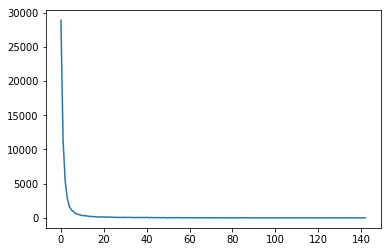

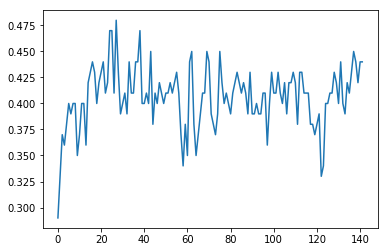

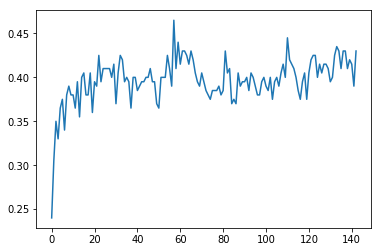

[0.29, 0.33, 0.37, 0.36, 0.38, 0.4, 0.39, 0.4, 0.4, 0.35, 0.37, 0.4, 0.4, 0.36, 0.42, 0.43, 0.44, 0.43, 0.4, 0.42, 0.43, 0.44, 0.41, 0.42, 0.47, 0.47, 0.41, 0.48, 0.43, 0.39, 0.4, 0.41, 0.39, 0.44, 0.41, 0.41, 0.44, 0.44, 0.47, 0.4, 0.4, 0.41, 0.4, 0.45, 0.38, 0.41, 0.4, 0.42, 0.41, 0.4, 0.41, 0.41, 0.42, 0.41, 0.42, 0.43, 0.41, 0.37, 0.34, 0.38, 0.35, 0.44, 0.45, 0.38, 0.35, 0.37, 0.39, 0.41, 0.41, 0.45, 0.44, 0.39, 0.38, 0.37, 0.39, 0.45, 0.42, 0.4, 0.41, 0.4, 0.39, 0.41, 0.42, 0.43, 0.42, 0.41, 0.42, 0.41, 0.39, 0.43, 0.39, 0.39, 0.4, 0.39, 0.39, 0.41, 0.41, 0.36, 0.4, 0.43, 0.41, 0.41, 0.43, 0.41, 0.4, 0.42, 0.39, 0.42, 0.42, 0.43, 0.42, 0.38, 0.43, 0.43, 0.41, 0.41, 0.41, 0.38, 0.38, 0.37, 0.38, 0.39, 0.33, 0.34, 0.4, 0.4, 0.41, 0.41, 0.43, 0.42, 0.4, 0.44, 0.4, 0.39, 0.42, 0.41, 0.43, 0.45, 0.44, 0.42, 0.44, 0.44]
[0.24, 0.305, 0.35, 0.33, 0.365, 0.375, 0.34, 0.38, 0.39, 0.38, 0.38, 0.365, 0.395, 0.355, 0.4, 0.405, 0.38, 0.38, 0.405, 0.36, 0.395, 0.39, 0.425, 0.395, 0.41, 0.41, 0

In [26]:
plt.plot(train_loss)
plt.show()
plt.plot(valid_accuracy)
plt.show()
plt.plot(test_accuracy)
plt.show()
print(valid_accuracy)
print(test_accuracy)
print("validation accuracy is , ", max(valid_accuracy))
print("maximum test accuracy is , ", max(test_accuracy))
print("correct test accuracy i.e test accuracy where validation is highest is ", test_accuracy[valid_accuracy.index(max(valid_accuracy))])

In [20]:
encoder_mask = RNN_Encoder_Masks(vocab_sz=1000, emb_sz=400, weight_p=0,
                                                 n_hid=256, n_layers=2, pad_token=0, qrnn=False).to(device)
dropout = LockedDropout(0.1)
classifier = PoolingLinearClassifierMask(layers=[400*3, 50, 300], drops=[0.4, 0.1]).to(device)

TypeError: __init__() takes 2 positional arguments but 3 were given

In [ ]:
encoder = RNN_Encoder(ntoken=1000, emb_sz=400, 
                                                 n_hid=256, n_layers=2, pad_token=0, qrnn=False).to(device)

In [ ]:
s = 9
b = 10
x = torch.randint(0,1000,(b,s))
# x[1,6:] = 0
# x[2,4:] = 0
# x[3,6:] = 0
x_ = torch.tensor(x,dtype=torch.long,device=device)
print(x_.shape)
output = encoder(x_)
# output = classifier(encoder(x))
# out = dropout(output[-1])

In [ ]:
output[-1][-1][-1].shape

In [ ]:
out_mask = encoder_mask(x_.transpose(1,0))
out = encoder(x_)

In [ ]:
a,len =  pad_packed_sequence(pack_sequence(x_))

In [ ]:
len

In [ ]:
plt.plot(train_loss)
plt.show()

plt.plot(valid_accuracy)
plt.show()

plt.plot(test_accuracy)
plt.show()


In [ ]:
a[0].shape

In [ ]:
# output = output[-1][-1]
a = output.view(output.size(0)*output.size(1), output.size(2))

In [ ]:
print(output[-1][-1][-1].shape)
print(output[-1][-1].permute(1,2,0)[:,:,-1].shape)
torch.equal(output[-1][-1][-1],output[-1][-1].permute(1,2,0)[:,:,-1])